In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
!pip install keras
!pip install torch
# !pip install tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 70.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 60.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 56.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 91.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 66.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 83.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 86.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 92.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 139.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
def solution(x_test_df, train_df):
    import numpy as np
    from skimage.transform import resize
    from sklearn.preprocessing import LabelEncoder
    import numpy as np
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim

    class Net(nn.Module):
        # 参考：　https://qiita.com/ryu1104/items/b2190df39933966e13b0
        def __init__(self):
            super(Net, self).__init__()
            # x(入力)のユニット数は28*28
            self.fc1 = nn.Linear(28*28, 10)
            # 隠れ層1のユニット数は10
            self.fc2 = nn.Linear(10, 10)
            # 隠れ層2のユニット数は10 ８クラスとして出力
            self.fc3 = nn.Linear(10, 8)
    
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.log_softmax(self.fc3(x),dim=1)
            return x
    
    # 参考: https://qiita.com/ryu1104/items/b2190df39933966e13b0
    
    def get_x_data(df, is_fit=True, size=1.0):
        #画像を共通のサイズにリサイズ
        target_size = (28, 28)
        resized_images = []
        for img in df['waferMap']:
            resized_img = resize(img, target_size, anti_aliasing=True)
            resized_img = resized_img.flatten()
            resized_images.append(resized_img)
    
        _X_data = np.array(resized_images) #NumPy配列に変換
        X_data = _X_data
        
        return X_data
    
    le = LabelEncoder() # ラベルエンコーダのインスタンスを作成
    X_train = get_x_data(train_df)
    y_train = le.fit_transform(np.array(train_df['failureType']))
    X_test = get_x_data(x_test_df, False)

    x = torch.tensor(X_train,dtype = torch.float) # テンソル・・・。
    y = torch.tensor(y_train)
    
    model = Net() # 学習モデルのインスタンスを作成
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss() # 損失関数の定義

    # HACKME: データローダーが必要？
    # HACKME: テンソルデータセットが必要？
    # HACKME: 正規化が必要？
    
    epoch = 5000
    sum_loss = 0.0 
    for i in range(1,epoch):
        optimizer.zero_grad() # 勾配の初期化
        output = model(x) # 説明変数xをネットワークにかける
        loss = criterion(output, y) # 損失関数の計算
        loss.backward() # 勾配の計算 
        optimizer.step() # パラメタの更新
    
        sum_loss += loss.item()
        if i % 1000 == 0:
            print("loss : {0}".format(sum_loss/i))
    
    outputs = model(torch.tensor(X_test, dtype = torch.float))
    _, predicted = torch.max(outputs.data, 1)
    y_pred = le.inverse_transform(predicted)
    
    return pd.DataFrame({'failureType': y_pred}, index=x_test_df.index)

In [4]:
# %%timeit -r 1 -n 1

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")
    
# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))

    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")

loss : 1.7644324576854706
loss : 1.7071206650137902
loss : 1.6855108790795008
loss : 1.6742142238616944
平均精度：12.50%


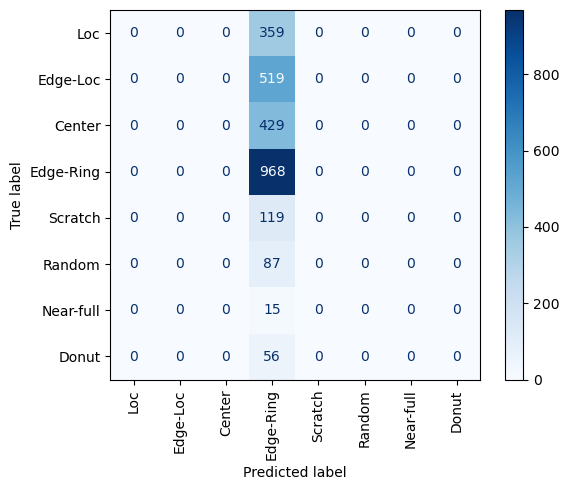

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 参考：https://qiita.com/wakame1367/items/5420ac91702edf993124
# 恐らく、こんな意味↓ ドキュメント見てもよくわからんかった。
# y_pred: 予測したfailureType, y_true: 正解のfailureType
labels = df['failureType'].unique()
cm = confusion_matrix(y_pred=user_result_df['failureType'], y_true=y_test_df['failureType'], labels=labels)
# display_labels: 集計して表示するラベル。
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)

cmp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')


In [6]:
#
# 誤分類したものを閲覧する。
#
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

# 画像の表示関数
def image_show(target_df, y_test_df, x_test_df, user_result_df, x=0): 
    ori_image = x_test_df.waferMap[x]
    true_label = y_test_df.failureType[x]
    result_label = user_result_df.failureType[x]
    print('true label  :', true_label)
    print('result label:', result_label)
    plt.imshow(ori_image)
    plt.show()
    return x

# failureType 選択関数
def select_type(failureType='Loc'): 
    drop_indexes = []
    for index in range(len(user_result_df)):
        true_df = y_test_df.iloc[index]
        result_df = user_result_df.iloc[index]
        if true_df.failureType != failureType:
            drop_indexes.append(true_df.name)
            continue
        if true_df.failureType == result_df.failureType:
            drop_indexes.append(true_df.name)
    filterd_df = x_test_df.drop(index=drop_indexes)
    num_widget = widgets.IntSlider(
        value=0,
        min=0,
        max=len(filterd_df.waferMap) - 1
    )
    interact(image_show,
        x=num_widget,
        target_df=fixed(x_test_df.drop(index=drop_indexes).reset_index()),
        y_test_df=fixed(y_test_df.drop(index=drop_indexes).reset_index()),
        x_test_df=fixed(x_test_df.drop(index=drop_indexes).reset_index()),
        user_result_df=fixed(user_result_df.drop(index=drop_indexes).reset_index()),
    );

labels = y_test_df.failureType.unique() # ラベル取得
interact(select_type, failureType=labels); # failureType選択

interactive(children=(Dropdown(description='failureType', index=2, options=('Edge-Ring', 'Edge-Loc', 'Loc', 'R…